In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 4)

import warnings
warnings.filterwarnings('ignore')

/Users/ivamilojkovic/opt/anaconda3/envs/bca_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load one sheet/table about DFS
df_clinical_dfs = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA-PANCA DFS')
df_clinical_dfs.head()

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971


In [3]:
# Load one sheet/table about OS
df_clinical_os = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA PANCA OS')
print(df_clinical_os.shape)
df_clinical_os.head()

(1084, 4)


,Study ID,Patient ID,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,LIVING,11.440971


In [4]:
# Get the name of the columns that need to be added
df_clinical_out_cols = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='EXAMPLE output - OS DFS SUBTYPE').columns
df_clinical_out_cols = df_clinical_out_cols[:-2]
df_clinical_out_cols

Index(['Patient ID', 'DFS_STATUS', 'DFS_MONTHS', 'RECURRED BEFORE 5 YEARS',
       'RECURRED AFTER FIVE YEARS', 'DISEASE FREE FOR LESS THAN 5 YEARS',
       'DISEASE FREE FOR MORE THAN 5 YEARS', 'OS_STATUS', 'OS_MONTHS',
       'DECEASED WITHIN 5 YEARS', 'SUBTYPE', 'IS LUMA',
       'TRAINING OR TESTING?'],
      dtype='object')

In [5]:
# Load the multilabel dataset (contains genes, correlations)
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    df_multi = pickle.load(file)

# Set negative correlations to zero
df_multi = discard_negative_correlations(df_multi)

print(df_multi.shape)
df_multi.head()

(1053, 25159)


,tcga_id,expert_PAM50_subtype,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,ZYX,ZZEF1,ZZZ3,Subtype-from Parker centroids,MaxCorr,Basal,Her2,LumA,LumB,Normal
0,TCGA-3C-AAAU,LumA,57898,67829,134,1697402,44314,1737,568,0,...,1054121,557596,409660,LumA,0.373445,0.0,0.000000,0.373445,0.179928,0.000000
1,TCGA-3C-AALI,Her2,52146,65152,1361,1403901,36852,1636,1357,41,...,1041074,247545,88163,Her2,0.647827,0.0,0.647827,0.000000,0.247731,0.000000
2,TCGA-3C-AALJ,LumB,52172,29356,510,989281,30378,282,1974,119,...,613785,110466,68745,LumB,0.357503,0.0,0.000000,0.144970,0.357503,0.000000
3,TCGA-3C-AALK,LumA,50517,43436,287,2674831,69374,816,2084,172,...,1397623,196615,206477,LumA,0.666747,0.0,0.000000,0.666747,0.000000,0.458535
4,TCGA-4H-AAAK,LumA,66433,66229,192,2279532,56667,1603,2425,246,...,970767,199472,246179,LumA,0.556303,0.0,0.000000,0.556303,0.000000,0.503962


In [6]:
# Merge the dataframes based on the 'ID' column (keep in mind, some NaNs will appear)
merged_df = pd.merge(df_clinical_dfs, df_clinical_os, on=['Patient ID', 'Study ID'])
print('Unique values in OS_STATUS columns: ', merged_df['OS_STATUS'].unique())
merged_df

Unique values in OS_STATUS columns:  ['LIVING' 'DECEASED' nan]


,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971
...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569


In [7]:
# Add new columns linked to time (5 years in this case)
merged_df['DISEASE FREE FOR MORE THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['DISEASE FREE FOR LESS THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] <= 5*12)
merged_df['RECURRED AFTER 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['RECURRED BEFORE 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] <= 5*12)
merged_df['DECEASED WITHIN 5 YEARS'] = (merged_df['OS_STATUS'] == 'DECEASED') & (merged_df['OS_MONTHS'] <= 5*12)
merged_df

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958,False,False,False,False,False
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819,False,True,False,False,False
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256,False,True,False,False,False
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660,False,True,False,False,False
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569,False,False,False,False,False


In [8]:
# Rename tcga_id columns
df_multi.rename(columns={'tcga_id': 'Patient ID'}, inplace=True)

# Connect the original multilabel dataset and previously formed DataFrame with DFS and OS information
df_multi_merged = pd.merge(df_multi, merged_df, on='Patient ID', how='left')
df_multi_merged.drop(columns=df_multi_merged.columns[2:-9], inplace=True)
df_multi_merged

,Patient ID,expert_PAM50_subtype,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False
3,TCGA-3C-AALK,LumA,NaN,NaN,LIVING,47.604958,False,False,False,False,False
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False


In [9]:
# Check how many rows have NaNs
df_multi_merged.isna().sum(axis=0)

Patient ID                              0
expert_PAM50_subtype                    0
DFS_STATUS                            140
DFS_MONTHS                            141
OS_STATUS                               5
OS_MONTHS                               6
DISEASE FREE FOR MORE THAN 5 YEARS      5
DISEASE FREE FOR LESS THAN 5 YEARS      5
RECURRED AFTER 5 YEARS                  5
RECURRED BEFORE 5 YEARS                 5
DECEASED WITHIN 5 YEARS                 5
dtype: int64

In [10]:
# Remove NaN rows and check if they are removed
df_multi_merged.dropna(inplace=True)
df_multi_merged.isna().sum()

Patient ID                            0
expert_PAM50_subtype                  0
DFS_STATUS                            0
DFS_MONTHS                            0
OS_STATUS                             0
OS_MONTHS                             0
DISEASE FREE FOR MORE THAN 5 YEARS    0
DISEASE FREE FOR LESS THAN 5 YEARS    0
RECURRED AFTER 5 YEARS                0
RECURRED BEFORE 5 YEARS               0
DECEASED WITHIN 5 YEARS               0
dtype: int64

# Creating DataFrames with Model Predictions

Since 6 models were selected each one of them gives prediction which will be used to create new datasets. These datasets will contain DFS, OS information, ground truth subtype from PAM50, information if a sample is predicted as LumA, taking into consideration the rank of the prediction (primary or secondary).

In [11]:
# Load test data (the split is the same as in the training workflow)
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    data = pickle.load(file)
    X = data.drop(columns=['expert_PAM50_subtype', 'tcga_id',
                           'Subtype-from Parker centroids',	'MaxCorr',
                            'Basal', 'Her2', 'LumA', 'LumB', 'Normal'], inplace=False)
    y_orig = data.expert_PAM50_subtype
    y_pam50 = data['Subtype-from Parker centroids']

    # Take labels on whole dataset for PAM50
    y_corr = data[['Basal', 'Her2', 'LumA', 'LumB',	'Normal']]
    y_corr_non_neg = discard_negative_correlations(y_corr)

    # M-cut strategy to assign labels on whole dataset
    y_mcut_labels, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=True)
    y_mcut_labels_neg, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=False)
    
    # Compute labels from two strategies (M-cut and 5th percentile)
    y_mcut_5perc_labels = create_mcut_nth_percentile_labels(
        m_cut_labels=y_mcut_labels,
        correlations=y_corr_non_neg,
        y=y_pam50,
        keep_primary=True,
        N=5
    )
    
    X_train, X_test, \
    y_train_pam50, y_test_pam50, \
    y_train_mcut, y_test_mcut, \
    y_train_orig, y_test_orig, \
    y_train_5perc, y_test_5perc = \
        train_test_split(X, y_pam50, y_mcut_labels, y_orig, 
                        y_mcut_5perc_labels, test_size=0.3, random_state=1, stratify=y_pam50)

    # Data standardization | normalization
    X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
    X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
    scaler = FunctionTransformer(log_transform)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Feature selection (based on original case)
    best_feat_model = SelectKBest(score_func=f_classif, k=500) 
    best_feat_model.fit(X_train_scaled, y_train_orig)
    df_scores = pd.DataFrame(best_feat_model.scores_)
    df_feats = pd.DataFrame(X.columns)

    featureScores = pd.concat([df_feats, df_scores],axis=1)
    featureScores.columns = ['Feature', 'Score'] 

    selected_feat = featureScores.sort_values(by='Score')[-500:]['Feature']

    X_train_scaled_selected = X_train_scaled[list(selected_feat)]
    X_test_scaled_selected = X_test_scaled[list(selected_feat)]

    # One-hot encoding of original and PAM50 labels
    y_train_orig = pd.get_dummies(y_train_orig)
    y_test_orig = pd.get_dummies(y_test_orig)
    y_train_pam50 = pd.get_dummies(y_train_pam50)
    y_test_pam50 = pd.get_dummies(y_test_pam50)

    # Merged train and test
    X_scaled_selected = pd.concat([X_train_scaled_selected, X_test_scaled_selected], axis=0)
    X_scaled_selected = X_scaled_selected.sort_index()


In [12]:
# Get test indices (here we are using only labels obtained with M-cut strategy and 5th percentile filtering)
test_idx = y_test_5perc.index
test_tcga_idx = df_multi.iloc[test_idx, 0]
test_tcga_idx

34     TCGA-AC-A6IW
786    TCGA-C8-A27A
451    TCGA-AC-A2QI
11     TCGA-A2-A0YE
599    TCGA-D8-A27I
           ...     
995    TCGA-A2-A25B
917    TCGA-C8-A26X
148    TCGA-C8-A8HR
946    TCGA-AN-A0FN
991    TCGA-A1-A0SN
Name: Patient ID, Length: 316, dtype: object

In [13]:
# Loading the best models for each approach

with open('../models/multi-label_models/ml_best_model_lr03-07-2023_00:31:05.pkl', 'rb') as f:
    model_xgb_br = pickle.load(f)

with open('../models/multi-label_models/ml_chain_best_model_lr03-07-2023_02:03:48.pkl', 'rb') as f:
    model_xgb_cc = pickle.load(f)

with open('../models/multi-label_models/ml_best_model_lr05-07-2023_00:43:55.pkl', 'rb') as f:
    model_lr_br = pickle.load(f)

with open('../models/multi-label_models/ml_chain_best_model_lr05-07-2023_00:58:18.pkl', 'rb') as f:
    model_lr_cc = pickle.load(f)

with open('../models/multi-label_models/ml_best_model_lr06-07-2023_10:17:57.pkl', 'rb') as f:
    model_svm_lp = pickle.load(f)

with open('../models/multi-label_models/ml_best_model_lr05-07-2023_00:27:34.pkl', 'rb') as f:
    model_rf_lp = pickle.load(f)

In [14]:
## Get the predictions and probabilities for each model and set the original test indices

# XGBoost
xgb_br_preds = model_xgb_br.predict(X_test_scaled_selected).toarray()
xgb_br_preds = pd.DataFrame(xgb_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_cc_preds = model_xgb_cc.predict(X_test_scaled_selected).toarray()
xgb_cc_preds = pd.DataFrame(xgb_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_br_prob_preds = model_xgb_br.predict_proba(X_test_scaled_selected).toarray()
xgb_br_prob_preds = pd.DataFrame(xgb_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_cc_prob_preds = model_xgb_cc.predict_proba(X_test_scaled_selected).toarray()
xgb_cc_prob_preds = pd.DataFrame(xgb_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# Logistic Regression
lr_br_preds = model_lr_br.predict(X_test_scaled_selected).toarray()
lr_br_preds = pd.DataFrame(lr_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_cc_preds = model_lr_cc.predict(X_test_scaled_selected).toarray()
lr_cc_preds = pd.DataFrame(lr_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_br_prob_preds = model_lr_br.predict_proba(X_test_scaled_selected).toarray()
lr_br_prob_preds = pd.DataFrame(lr_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_cc_prob_preds = model_lr_cc.predict_proba(X_test_scaled_selected).toarray()
lr_cc_prob_preds = pd.DataFrame(lr_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# SVM
svm_lp_preds = model_svm_lp.predict(X_test_scaled_selected).toarray()
svm_lp_preds = pd.DataFrame(svm_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

svm_lp_prob_preds = model_svm_lp.predict_proba(X_test_scaled_selected).toarray()
svm_lp_prob_preds = pd.DataFrame(svm_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# Random Forest
rf_lp_preds = model_rf_lp.predict(X_test_scaled_selected).toarray()
rf_lp_preds = pd.DataFrame(rf_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

rf_lp_prob_preds = model_rf_lp.predict_proba(X_test_scaled_selected).toarray()
rf_lp_prob_preds = pd.DataFrame(rf_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)


In [15]:
# Function to set "test" or "train"
def set_test_or_train(id_value):
    if str(id_value) in test_tcga_idx.values:
        return "test"
    else:
        return "train"
    
# Function to get custom sorted indices for each row
def rank_indices(row):
    return row.rank(ascending=False).astype(int)
    
def df_formatting(df: pd.DataFrame, preds: pd.DataFrame, probs: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Take into account the rank of prediction i.e. labels
    ranked_indices = probs.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=probs.columns, index=probs.index)
    rank_preds = preds * ranked_corr_df

    # Create the new column using apply()
    df_new['TRAINING OR TESTING'] =  df_new["Patient ID"].apply(set_test_or_train)
    df_new.rename(columns={'expert_PAM50_subtype': 'SUBTYPE'}, inplace=True)
    df_new.rename(columns={'Subtype-from Parker centroids': 'PAM50 SUBTYPE'})
    df_new['IS LUMA'] = preds['LumA'].astype('bool')
    df_new['IS LUMA PRIMARY'] = rank_preds['LumA'] == 1
    df_new['IS LUMA SECONDARY'] = rank_preds['LumA'] == 2

    return df_new

df_xgb_br = df_formatting(df_multi_merged, xgb_br_preds, xgb_br_prob_preds)
df_xgb_cc = df_formatting(df_multi_merged, xgb_cc_preds, xgb_cc_prob_preds)
df_lr_br = df_formatting(df_multi_merged, lr_br_preds, lr_br_prob_preds)
df_lr_cc = df_formatting(df_multi_merged, lr_cc_preds, lr_cc_prob_preds)
df_svm_lp = df_formatting(df_multi_merged, svm_lp_preds, svm_lp_prob_preds)
df_rf_lp = df_formatting(df_multi_merged, rf_lp_preds, rf_lp_prob_preds)

In [16]:
df_xgb_br

,Patient ID,SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,train,NaN,NaN,NaN
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,test,False,False,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,train,NaN,NaN,NaN
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,test,True,True,False
7,TCGA-A1-A0SG,LumA,DiseaseFree,14.268337,LIVING,14.268337,False,True,False,False,False,train,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,train,NaN,NaN,NaN
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,train,NaN,NaN,NaN
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False,test,False,False,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False,test,True,False,True


In [17]:
# Extract only test samples
df_xgb_br_test = df_xgb_br[df_xgb_br['TRAINING OR TESTING'] == 'test']
df_xgb_cc_test = df_xgb_cc[df_xgb_cc['TRAINING OR TESTING'] == 'test']
df_lr_br_test = df_lr_br[df_lr_br['TRAINING OR TESTING'] == 'test']
df_lr_cc_test = df_lr_cc[df_lr_cc['TRAINING OR TESTING'] == 'test']
df_svm_lp_test = df_svm_lp[df_svm_lp['TRAINING OR TESTING'] == 'test']
df_rf_lp_test = df_rf_lp[df_rf_lp['TRAINING OR TESTING'] == 'test']

# Extract only train samples
df_xgb_br_train = df_xgb_br[df_xgb_br['TRAINING OR TESTING'] == 'train']
df_xgb_cc_train = df_xgb_cc[df_xgb_cc['TRAINING OR TESTING'] == 'train']
df_lr_br_train = df_lr_br[df_lr_br['TRAINING OR TESTING'] == 'train']
df_lr_cc_train = df_lr_cc[df_lr_cc['TRAINING OR TESTING'] == 'train']
df_svm_lp_train = df_svm_lp[df_svm_lp['TRAINING OR TESTING'] == 'train']
df_rf_lp_train = df_rf_lp[df_rf_lp['TRAINING OR TESTING'] == 'train']

In [18]:
# Modify training data since it has NaNs 
# (the labels and ranks need to be extracyed from memberships and m-cut + 5perc labels)

# Perker subtype is a primary
df_xgb_br_train['IS LUMA'] = df_multi.loc[df_xgb_br_train.index, 'Subtype-from Parker centroids'] == 'LumA'
df_xgb_br_train['IS LUMA PRIMARY'] = df_multi.loc[df_xgb_br_train.index, 'Subtype-from Parker centroids'] == 'LumA'

# Take into account the rank of prediction i.e. labels
memberships = df_multi.iloc[df_xgb_br_train.index, -5:]
ranked_indices = memberships.apply(rank_indices, axis=1)

# Create DataFrame from ranked values
rank_membs = ranked_indices * y_mcut_5perc_labels.loc[df_xgb_br_train.index]

df_xgb_br_train['IS LUMA SECONDARY'] = rank_membs['LumA'] == 2

df_xgb_br_train

,Patient ID,SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,train,True,True,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,train,False,False,False
7,TCGA-A1-A0SG,LumA,DiseaseFree,14.268337,LIVING,14.268337,False,True,False,False,False,train,True,True,False
8,TCGA-A1-A0SO,Basal,DiseaseFree,28.010652,LIVING,28.010652,False,True,False,False,False,train,False,False,False
9,TCGA-A2-A0CX,Her2,DiseaseFree,56.810336,LIVING,56.810336,False,True,False,False,False,train,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,TCGA-AR-A2LQ,Normal,DiseaseFree,40.536542,LIVING,40.536542,False,True,False,False,False,train,False,False,True
1045,TCGA-B6-A0RQ,Normal,DiseaseFree,140.283394,DECEASED,140.283394,True,False,False,False,False,train,False,False,True
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,train,False,False,True
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,train,False,False,False


In [19]:
df_xgb_br_train

,Patient ID,SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,train,True,True,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,train,False,False,False
7,TCGA-A1-A0SG,LumA,DiseaseFree,14.268337,LIVING,14.268337,False,True,False,False,False,train,True,True,False
8,TCGA-A1-A0SO,Basal,DiseaseFree,28.010652,LIVING,28.010652,False,True,False,False,False,train,False,False,False
9,TCGA-A2-A0CX,Her2,DiseaseFree,56.810336,LIVING,56.810336,False,True,False,False,False,train,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,TCGA-AR-A2LQ,Normal,DiseaseFree,40.536542,LIVING,40.536542,False,True,False,False,False,train,False,False,True
1045,TCGA-B6-A0RQ,Normal,DiseaseFree,140.283394,DECEASED,140.283394,True,False,False,False,False,train,False,False,True
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,train,False,False,True
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,train,False,False,False


# Kaplan Meier survival curves

The survival analysis measures the time to an event which in our case can be:
* dicease free for more and for less than 5 years
* recurred after and before 5 years
* diceased within 5 years

Before obtaining KM curves, two groups need to be made, and these are the scenarios we are going to analyze:
* LumA (no matter the rank) vs. not LumA
* LumA primary vs. not LumA
* LumA secondary vs. not LumA


In [20]:
# Create groups
def create_groups(df: pd.DataFrame):
    group_not_LumA = df[df['IS LUMA'] == False]
    group_LumA = df[df['IS LUMA'] == True]
    group_LumA_primary = df[df['IS LUMA PRIMARY'] == True]
    group_LumA_secondary = df[df['IS LUMA SECONDARY'] == True]
    return group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary

group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary = create_groups(df_lr_br_test)

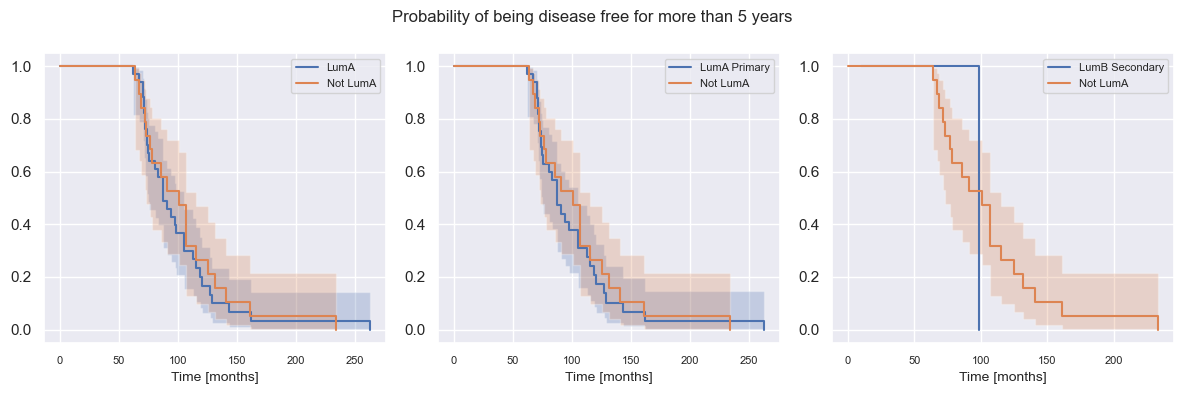

In [21]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumB Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['DISEASE FREE FOR MORE THAN 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['DISEASE FREE FOR MORE THAN 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)

fig.suptitle('Probability of being disease free for more than 5 years', fontsize=12)

plt.tight_layout()

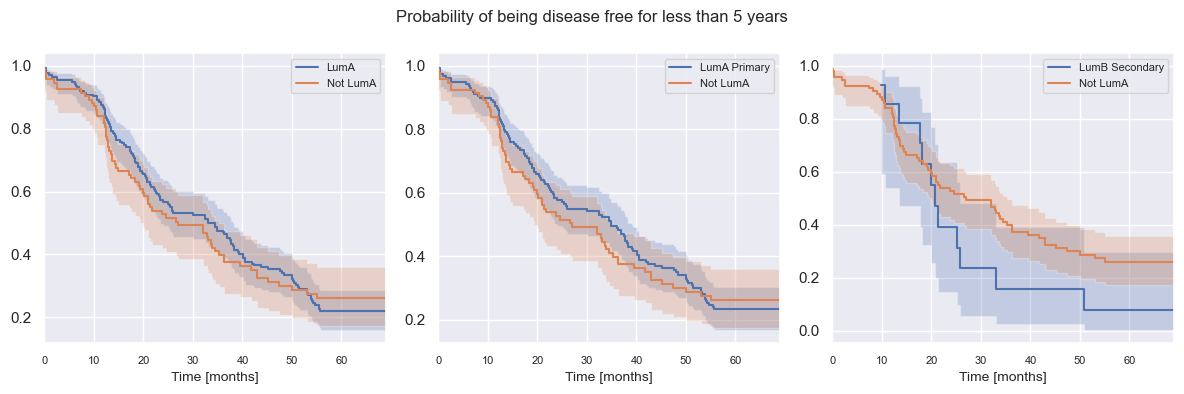

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumB Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['DISEASE FREE FOR LESS THAN 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['DISEASE FREE FOR LESS THAN 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([0, 69])

fig.suptitle('Probability of being disease free for less than 5 years', fontsize=12)

plt.tight_layout()

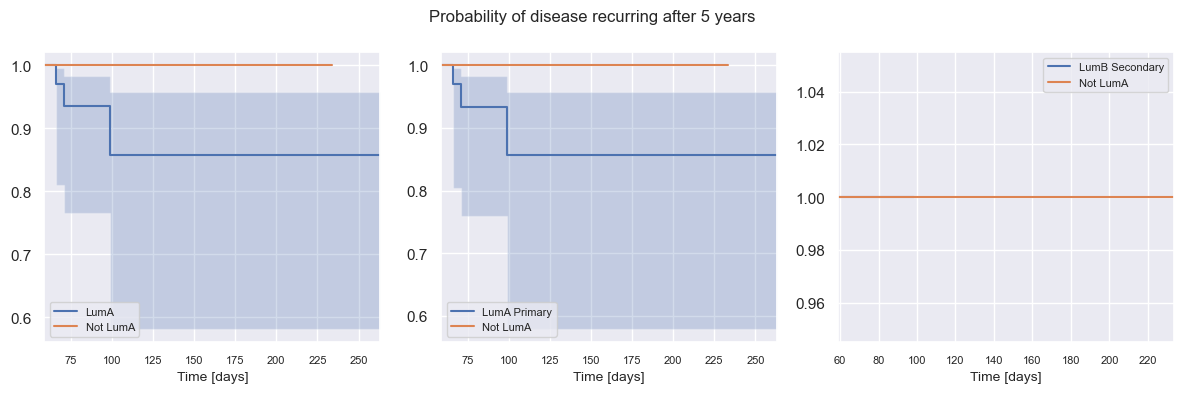

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumB Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['RECURRED AFTER 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['RECURRED AFTER 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [days]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([59, max(max(time), max(time_not_LumA))])

fig.suptitle('Probability of disease recurring after 5 years', fontsize=12)

plt.tight_layout()

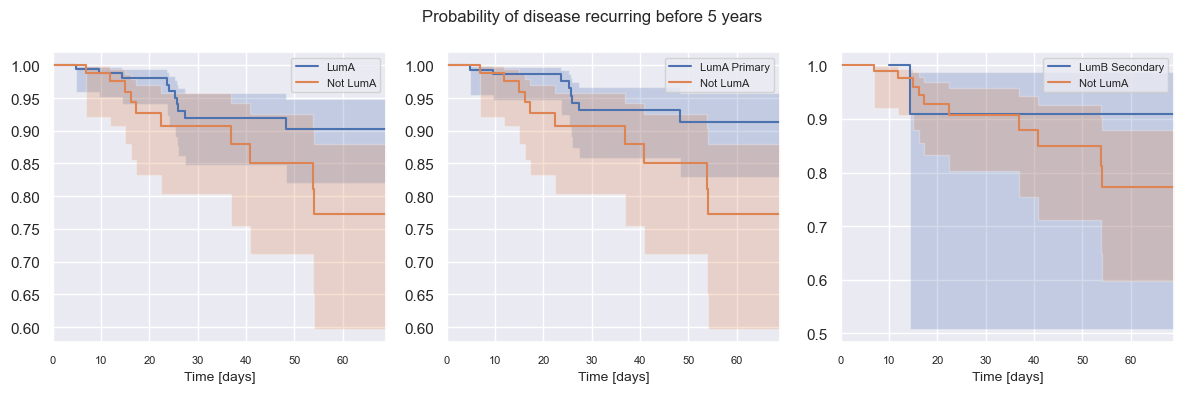

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumB Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['RECURRED BEFORE 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['RECURRED BEFORE 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [days]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([0, 69])

fig.suptitle('Probability of disease recurring before 5 years', fontsize=12)

plt.tight_layout()


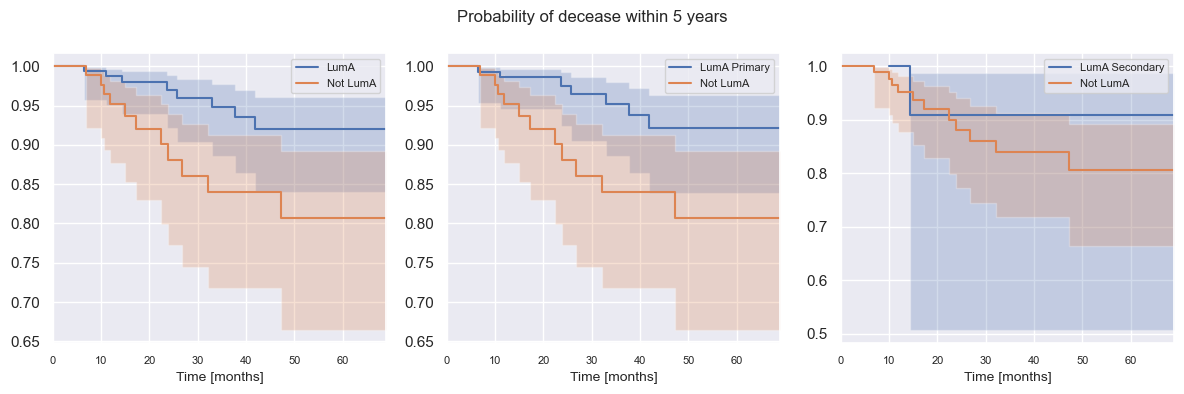

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumA Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([0,69])

fig.suptitle('Probability of decease within 5 years', fontsize=12)

plt.tight_layout()


## Now do the same just with all data (not only test samples)...

There are two ways to do so:
1. Apply the model to get the predictions on the whole dataset
2. Take the predictions only from the test set, but for the train set use the m-cut labels and create ranks based on memberships

In [26]:
xgb_br_preds_all = model_xgb_br.predict(X_scaled_selected).toarray()
xgb_br_preds_all = pd.DataFrame(xgb_br_preds_all, columns=y_mcut_5perc_labels.columns, index=y_mcut_5perc_labels.index)

xgb_br_probs_all = model_xgb_br.predict_proba(X_scaled_selected).toarray()
xgb_br_probs_all = pd.DataFrame(xgb_br_probs_all, columns=y_mcut_5perc_labels.columns, index=y_mcut_5perc_labels.index)

df_xgb_br = df_formatting(df_multi_merged, xgb_br_preds_all, xgb_br_probs_all)
df_xgb_br

,Patient ID,SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY
0,TCGA-3C-AAAU,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,train,True,True,False
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,test,False,False,False
2,TCGA-3C-AALJ,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,train,False,False,False
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,test,True,True,False
7,TCGA-A1-A0SG,LumA,DiseaseFree,14.268337,LIVING,14.268337,False,True,False,False,False,train,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,train,True,False,True
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,train,False,False,False
1050,TCGA-EW-A1P7,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False,test,False,False,False
1051,TCGA-EW-A1PG,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False,test,True,False,True


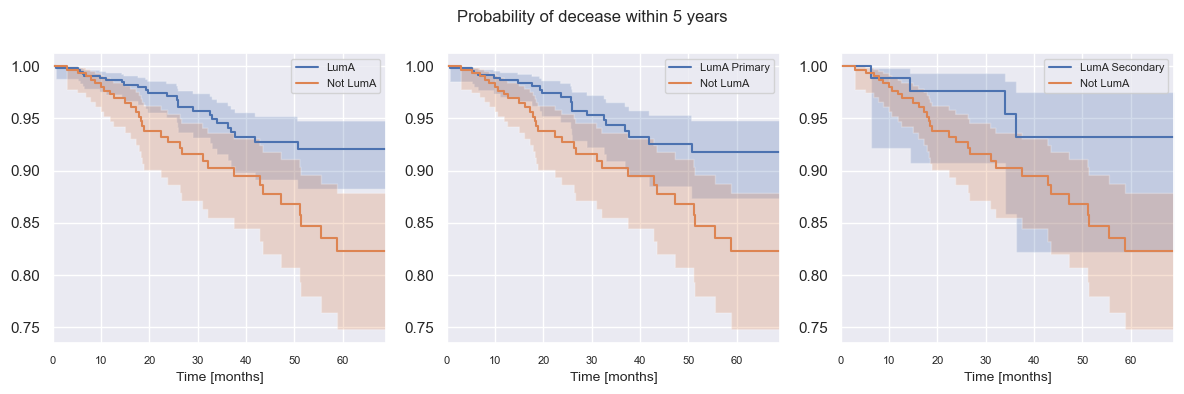

In [27]:
group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary = create_groups(df_xgb_br)

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumA Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([0,69])

fig.suptitle('Probability of decease within 5 years', fontsize=12)

plt.tight_layout()

In [28]:
xgb_br_preds_all = pd.concat([df_xgb_br_test, df_xgb_br_train])
xgb_br_preds_all

,Patient ID,SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY
1,TCGA-3C-AALI,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,test,False,False,False
4,TCGA-4H-AAAK,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,test,True,True,False
10,TCGA-A2-A0D1,Her2,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False,test,False,False,False
11,TCGA-A2-A0YE,Basal,DiseaseFree,18.213499,LIVING,18.213499,False,True,False,False,False,test,False,False,False
13,TCGA-A2-A4S1,Basal,DiseaseFree,26.958609,LIVING,26.958609,False,True,False,False,False,test,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,TCGA-AR-A2LQ,Normal,DiseaseFree,40.536542,LIVING,40.536542,False,True,False,False,False,train,False,False,True
1045,TCGA-B6-A0RQ,Normal,DiseaseFree,140.283394,DECEASED,140.283394,True,False,False,False,False,train,False,False,True
1048,TCGA-BH-A42U,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,train,False,False,True
1049,TCGA-E2-A108,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,train,False,False,False


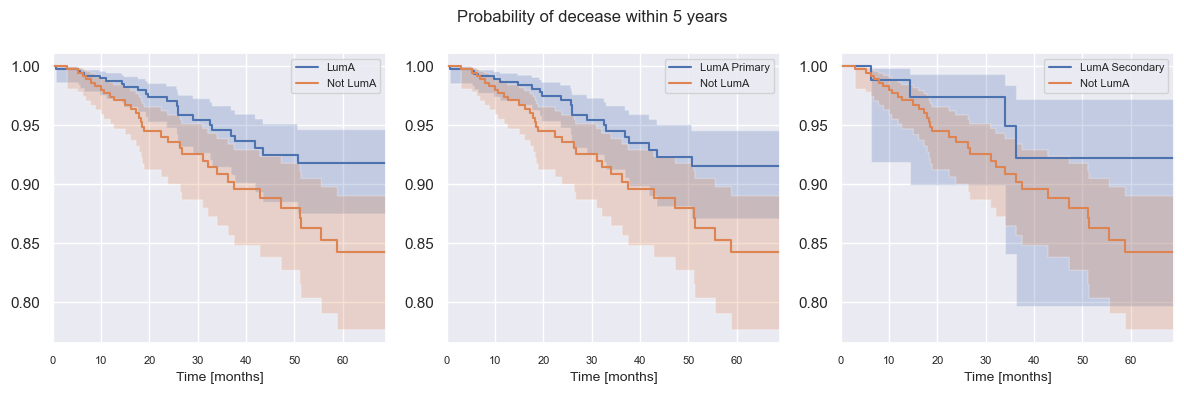

In [29]:
group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary = create_groups(xgb_br_preds_all)

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumA Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([0,69])

fig.suptitle('Probability of decease within 5 years', fontsize=12)

plt.tight_layout()

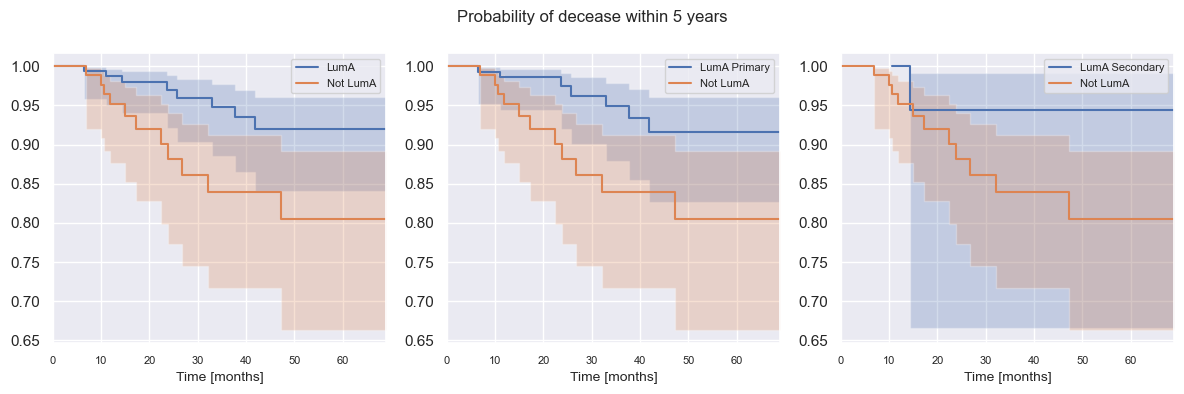

In [34]:
# Now do the same for other models
group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary = create_groups(df_rf_lp_test)

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumA Secondary']

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=df_group['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=df_group['DFS_MONTHS'], conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=group_not_LumA['DECEASED WITHIN 5 YEARS'].astype('bool'),
        time_exit=group_not_LumA['DFS_MONTHS'], conf_type='log-log'
    )

    axes[i].step(time, survival_prob, where='post', label=group_names[i])
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA')
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=10)
    axes[i].legend(loc='best', fontsize=8)
    axes[i].xaxis.set_tick_params(labelsize=8)
    axes[i].set_xlim([0,69])

fig.suptitle('Probability of decease within 5 years', fontsize=12)

plt.tight_layout()

In [ ]:
# Now plot the same for single label 
